In [1]:
# Copyright (c) 2018 The Harmonica Developers.
# Distributed under the terms of the BSD 3-Clause License.
# SPDX-License-Identifier: BSD-3-Clause
#
# This code is part of the Fatiando a Terra project (https://www.fatiando.org)
#
"""
FFT Based 2D Filter to potential field data
"""
import xrft
import numpy as np

class FFT_Filter:
    
    """
    Transform 2D potential field data use FFT based filter
    
    Workflow: Pad Data --> FFT --> Define and Apply Filter --> Inverse FFT --> Unpad Data
    

    Parameters
    ----------
    da: 2d-xarray
        This is the input 2D grid. Note, the input grid should be cartesian grid (northing, easting). 
        Geography grid (latitude,longitude) is invalid in here. 
        
    pad_width: None or list of arrays
        List containing the pad width [northing_pad_width, easting_pad_width] called by xrft.padding.pad. Default value is None,
        no padding apply to data.
        
    mode: str, default: "constant"
        str for control xrft.padding.pad function, One of the following string values (taken from numpy docs).
        - constant: Pads with a constant value.
        - edge: Pads with the edge values of array.
        - linear_ramp: Pads with the linear ramp between end_value and the
          array edge value.
        - maximum: Pads with the maximum value of all or part of the
          vector along each axis.
        - mean: Pads with the mean value of all or part of the
          vector along each axis.
        - median: Pads with the median value of all or part of the
          vector along each axis.
        - minimum: Pads with the minimum value of all or part of the
          vector along each axis.
        - reflect: Pads with the reflection of the vector mirrored on
          the first and last values of the vector along each axis.
        - symmetric: Pads with the reflection of the vector mirrored
          along the edge of the array.
        - wrap: Pads with the wrap of the vector along the axis.
          The first values are used to pad the end and the
          end values are used to pad the beginning.             
    
    """

    def __init__(self,da,pad_width=None,mode='constant',**kwargs):
        
        self.pad_width=pad_width
        self.da=da
        
        # Drop bad_coords
        for d in self.da.dims:
            bad_coords = [
                cname for cname in self.da.coords if cname != d and d in self.da[cname].dims
            ]
        for d in bad_coords:
            da=self.da.drop(bad_coords)

        # Pad Data
        if pad_width is None :
            da_padded = da
        else :
            da_padded = xrft.pad(da,{da.dims[0]:self.pad_width[0],da.dims[1]:self.pad_width[1]},mode)        
        
        # FFT
        da_fft = xrft.fft(da_padded,true_phase=True, true_amplitude=True)
        
        self.da_fft=da_fft

        # Frequency grids
        f_e, f_n = np.meshgrid(da_fft.coords[da_fft.dims[1]]*2*np.pi, da_fft.coords[da_fft.dims[0]]*2*np.pi)
        
        self.f_n=f_n
        self.f_e=f_e
    
    def fft(self):
        
        """
        Return forward fft result
    
        Returns
        -------
        da_fft : 2d-xarray
        """
        return self.da_fft

    def freq(self):
        
        """
        Return frequency grid [f_n,f_e]

        Returns
        -------
        f_n : 2d-array
        f_e : 2d-array
    
        """
        return self.f_n,self.f_e        
        
    def apply_filter(self,filter):
        
        """
        Apply filter and calculate Inverse FFT. Un_pad data if
        pad_with is not None.
        
        Parameters
        -------
        filter : 2d-array
            Apply pre-defined or custom filter 

        Returns
        -------
        da_unpad : 2d-xarray
            Xarray data in space domain after filtering.
        """       
         # Apply Filter
        da_filter = self.da_fft*filter
        # Inverse FFT
        da_ifft = xrft.ifft(da_filter,true_phase=True, true_amplitude=True)
        # Unpad Data
        if self.pad_width is None :
            da_unpad = da_ifft.real
        else :
            da_unpad=xrft.unpad(da_ifft.real,{da_ifft.dims[0]:self.pad_width[0],da_ifft.dims[1]:self.pad_width[1]}) 
            
        return da_unpad
    
    """
    -------
    Pre-defined filter lists as follows
    
    """        
    def derivative_e(self,order,savefilter=False,**kwargs):
        
        """
        Calculate n order horizental derivative along easting
        
        Parameters
        -------
        order : int
            The order of horizental derivative.
            
        savefilter : False or True
            If savefilter is False, direct apply filter to data, output in space domain.
            If savefilter is True, don't apply filter to data, output is the filter itself.
            
        Returns
        -------
        da_out : 2d-xarray
            Xarray data in space domain after apply filter. Need savefilter = False.
            
        filter : 2d-array
            filter itself. Need savefilter = True.
        """     
            
        filter=np.power(self.f_e*1j,order)
        
        if savefilter is False :
            # Apply Filter
            da_out = self.apply_filter(filter)
            return da_out
        else:
            return filter

    def derivative_n(self,order,savefilter=False,**kwargs):
        """
        Calculate n order horizental derivative along northing
        
        Parameters
        -------
        order : int
            The order of horizental derivative.
            
        savefilter : False or True
            If savefilter is False, direct apply filter to data, output in space domain.
            If savefilter is True, don't apply filter to data, output is the filter itself.
            
        Returns
        -------
        da_out : 2d-xarray
            Xarray data in space domain after apply filter. Need savefilter = False.
            
        filter : 2d-array
            filter itself. Need savefilter = True.
        """             
        filter=np.power(self.f_n*1j,order)
        
        if savefilter is False :
            # Apply Filter
            da_out = self.apply_filter(filter)
            return da_out
        else:
            return filter
        
    def derivative_v(self,order,savefilter=False,**kwargs):
        """
        Calculate n order vertical derivative
        
        Parameters
        -------
        order : int
            The order of vertical derivative.
            
        savefilter : False or True
            If savefilter is False, direct apply filter to data, output in space domain.
            If savefilter is True, don't apply filter to data, output is the filter itself.
            
        Returns
        -------
        da_out : 2d-xarray
            Xarray data in space domain after apply filter. Need savefilter = False.
            
        filter : 2d-array
            filter itself. Need savefilter = True.
        """  
        
        filter=np.power(np.sqrt(self.f_e**2+self.f_n**2),order)
        
        if savefilter is False :
            # Apply Filter
            da_out = self.apply_filter(filter)
            return da_out
        else:
            return filter

    def guassian_lp(self,wavelength,savefilter=False,**kwargs):
        
        """
        Filter data by Guassian Low-pass filter 
        
        Parameters
        -------
        wavelength : float
            The cut off wavelength for low-pass filter. It has same unit with input xarray data.
            
        savefilter : False or True
            If savefilter is False, direct apply filter to data, output in space domain.
            If savefilter is True, don't apply filter to data, output is the filter itself.
            
        Returns
        -------
        da_out : 2d-xarray
            Xarray data in space domain after apply filter. Need savefilter = False.
            
        filter : 2d-array
            filter itself. Need savefilter = True.
        """  
        
        filter=np.exp(-(self.f_e**2+self.f_n**2)/(2*(2*np.pi/wavelength)**2))
        
        if savefilter is False :
            # Apply Filter
            da_out = self.apply_filter(filter)
            return da_out
        else:
            return filter    

    def guassian_hp(self,wavelength,savefilter=False,**kwargs):

        """
        Filter data by Guassian High-pass filter 
        
        Parameters
        -------
        wavelength : float
            The cut off wavelength for high-pass filter. It has same unit with input xarray data.
            
        savefilter : False or True
            If savefilter is False, direct apply filter to data, output in space domain.
            If savefilter is True, don't apply filter to data, output is the filter itself.
            
        Returns
        -------
        da_out : 2d-xarray
            Xarray data in space domain after apply filter. Need savefilter = False.
            
        filter : 2d-array
            filter itself. Need savefilter = True.
        """  
        
        filter=1-np.exp(-(self.f_e**2+self.f_n**2)/(2*(2*np.pi/wavelength)**2))
        
        if savefilter is False :
            # Apply Filter
            da_out = self.apply_filter(filter)
            return da_out
        else:
            return filter 
        
    def upward_continuation(self,height,savefilter=False,**kwargs):

        """
        Upward continuation data by height 
        
        Parameters
        -------
        height : float
            Heigh for upward continuation. The value should be negtive. It has same unit with input xarray data.
            
        savefilter : False or True
            If savefilter is False, direct apply filter to data, output in space domain.
            If savefilter is True, don't apply filter to data, output is the filter itself.
            
        Returns
        -------
        da_out : 2d-xarray
            Xarray data in space domain after apply filter. Need savefilter = False.
            
        filter : 2d-array
            filter itself. Need savefilter = True.
        """  
        
        filter=np.exp(np.sqrt(self.f_e**2+self.f_n**2)*height)
        
        if savefilter is False :
            # Apply Filter
            da_out = self.apply_filter(filter)
            return da_out
        else:
            return filter
        
        
    def vertical_intergral(self,order=-1,savefilter=False,**kwargs):

        """
        Vertical intergral of potential field data 
        
        Parameters
        -------
        order : -1
            Vertical intergral. eg: transform gravity to gravity potential.
            
        savefilter : False or True
            If savefilter is False, direct apply filter to data, output in space domain.
            If savefilter is True, don't apply filter to data, output is the filter itself.
            
        Returns
        -------
        da_out : 2d-xarray
            Xarray data in space domain after apply filter. Need savefilter = False.
            
        filter : 2d-array
            filter itself. Need savefilter = True.
        """  
        
        filter=np.power(np.sqrt(self.f_e**2+self.f_n**2),order)

        filter=np.nan_to_num(filter,posinf=1,nan=1)

        if savefilter is False :
            # Apply Filter
            da_out = self.apply_filter(filter)
            return da_out
        else:
            return filter
        
    def rtp(self,I,D,Im=None,Dm=None,savefilter=False,**kwargs):
        
        """
        Reduce total field magnetic anomaly data to the pole. For low inclination
        area, RTP is not stable. Recommod reduce total field magnetic anomaly data
        to the equator (rte).
        
        Parameters
        -------
        I : float in degree
            The inclination inducing Geomagnetic field.
            
        D : float in degree
            The declination inducing Geomagnetic field. 
            
        Im : float in degree
            The inclination of the total magnetization of the anomaly source. Default is I,
            neglecting remanent magnetization and self demagnetization.
            
        Dm : float in degree
            The declination of the total magnetization of the anomaly source. Default is D,
            neglecting remanent magnetization and self demagnetization.
            
        savefilter : False or True
            If savefilter is False, direct apply filter to data, output in space domain.
            If savefilter is True, don't apply filter to data, output is the filter itself.

        North
        
        ^                      --------> Horizental
        |   /                  |\ I
        |D /                   | \
        | /                    |  \
        |/                     |   \
        --------> East         Up
        
        Returns
        -------
        da_out : 2d-xarray
            Xarray data in space domain after apply filter. Need savefilter = False.
            
        filter : 2d-array
            filter itself. Need savefilter = True.
        """  
        # Transform degree to rad
        [I,D]=np.deg2rad([I,D])
        
        if Dm is None or Im is None:
            [Im,Dm]=[I,D]
        else:
            [Im,Dm]=np.deg2rad([Im,Dm])
        
        filter=(self.f_n**2+self.f_e**2)/((1j*(np.cos(I)*np.sin(D)*self.f_e+np.cos(I)*np.cos(D)*self.f_n)+
                                           np.sin(I)*np.sqrt(self.f_n**2+self.f_e**2))*
                                          (1j*(np.cos(Im)*np.sin(Dm)*self.f_e+np.cos(Im)*np.cos(Dm)*self.f_n)+
                                           np.sin(Im)*np.sqrt(self.f_n**2+self.f_e**2)))
        # Deal with inf and nan value
        filter=np.nan_to_num(filter,posinf=0,nan=0)

        if savefilter is False :
            # Apply Filter
            da_out = self.apply_filter(filter)
            return da_out
        else:
            return filter     

    def rte(self,I,D,Im=None,Dm=None,savefilter=False,**kwargs):
        
        """
        Reduce total field magnetic anomaly data to the equator
        
        Parameters
        -------
        I : float in degree
            The inclination inducing Geomagnetic field.
            
        D : float in degree
            The declination inducing Geomagnetic field. 
            
        Im : float in degree
            The inclination of the total magnetization of the anomaly source. Default is I,
            neglecting remanent magnetization and self demagnetization.
            
        Dm : float in degree
            The declination of the total magnetization of the anomaly source. Default is D,
            neglecting remanent magnetization and self demagnetization.
            
        savefilter : False or True
            If savefilter is False, direct apply filter to data, output in space domain.
            If savefilter is True, don't apply filter to data, output is the filter itself.

        North
        
        ^                      --------> Horizental
        |   /                  |\ I
        |D /                   | \
        | /                    |  \
        |/                     |   \
        --------> East         Up
        
        Returns
        -------
        da_out : 2d-xarray
            Xarray data in space domain after apply filter. Need savefilter = False.
            
        filter : 2d-array
            filter itself. Need savefilter = True.
        """   
        
        # Transform degree to rad   
        [I,D]=np.deg2rad([I,D])
        
        if Dm is None or Im is None:
            [Im,Dm]=[I,D]
        else:
            [Im,Dm]=np.deg2rad([Im,Dm])
            

        filter=((1j*np.sin(D)*self.f_e+1j*np.cos(D)*self.f_n)**2)/((1j*(np.cos(I)*np.sin(D)*self.f_e+np.cos(I)*np.cos(D)*self.f_n)+
                                    np.sin(I)*np.sqrt(self.f_n**2+self.f_e**2))*
                                   (1j*(np.cos(Im)*np.sin(Dm)*self.f_e+np.cos(Im)*np.cos(Dm)*self.f_n)+
                                    np.sin(Im)*np.sqrt(self.f_n**2+self.f_e**2)))
        
        filter=np.nan_to_num(filter,posinf=0,nan=0)

        if savefilter is False :
            # Apply Filter
            da_out = self.apply_filter(filter)
            return da_out
        else:
            return filter     
        
    def pseudo_gravity(self,I,D,Im=None,Dm=None,F=50000,savefilter=False,**kwargs):

        """
        Pseudo gravity of total field magnetic anomaly data
        
        Parameters
        -------
        I : float in degree
            The inclination inducing Geomagnetic field.
            
        D : float in degree
            The declination inducing Geomagnetic field. 
            
        Im : float in degree
            The inclination of the total magnetization of the anomaly source. Default is I,
            neglecting remanent magnetization and self demagnetization.
            
        Dm : float in degree
            The declination of the total magnetization of the anomaly source. Default is D,
            neglecting remanent magnetization and self demagnetization.
            
        F : float or 2d-array
            Ambient field in the study area. It can use the mean ambinent field value in the study
            area or the real ambient field value in all locations. Default is 50,000 nT.
            
        savefilter : False or True
            If savefilter is False, direct apply filter to data, output in space domain.
            If savefilter is True, don't apply filter to data, output is the filter itself.

        North
        
        ^                      --------> Horizental
        |   /                  |\ I
        |D /                   | \
        | /                    |  \
        |/                     |   \
        --------> East         Up
        
        Returns
        -------
        da_out : 2d-xarray
            Xarray data in space domain after apply filter. Need savefilter = False.
            
        filter : 2d-array
            filter itself. Need savefilter = True.
        """   
        # Call rtp and vertical_intergral filter
        filter=self.rtp(I,D,Im,Dm,savefilter=True)*self.vertical_intergral(order=-1,savefilter=True)

        filter=np.nan_to_num(filter,posinf=0,nan=0)
        
        if savefilter is False :
            # Apply Filter
            da_out = self.apply_filter(filter)
            # Scale data by Ambient Field
            da_out = da_out/149.8/F
            return da_out
        else:
            return filter/149.8/F
        


## Example

In [2]:
%matplotlib inline

Number of data points: 7054
Mean height of observations: 541.8293166997448


C:\Users\22528618\Anaconda3\envs\fati\lib\site-packages\harmonica\equivalent_sources\cartesian.py:594: FutureWarning: The 'EQLHarmonic' class has been renamed to 'EquivalentSources' and will be deprecated on the next release, please use 'EquivalentSources' instead.
  warnings.warn(
C:\Users\22528618\Anaconda3\envs\fati\lib\site-packages\harmonica\equivalent_sources\cartesian.py:190: FutureWarning: The 'relative_depth' parameter is deprecated, please use the 'depth' paramter and set 'depth_type' to 'relative_depth' instead. 
  warnings.warn(
C:\Users\22528618\Anaconda3\envs\fati\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


R² score: 0.9988789670714482

Generated grid:
 <xarray.Dataset>
Dimensions:           (northing: 131, easting: 80)
Coordinates:
  * easting           (easting) float64 -3.24e+05 -3.234e+05 ... -2.769e+05
  * northing          (northing) float64 4.175e+06 4.176e+06 ... 4.253e+06
    upward            (northing, easting) float64 1.5e+03 1.5e+03 ... 1.5e+03
Data variables:
    magnetic_anomaly  (northing, easting) float64 30.67 30.74 ... 163.5 149.9
Attributes:
    metadata:  Generated by EQLHarmonic(damping=1, depth=1000)


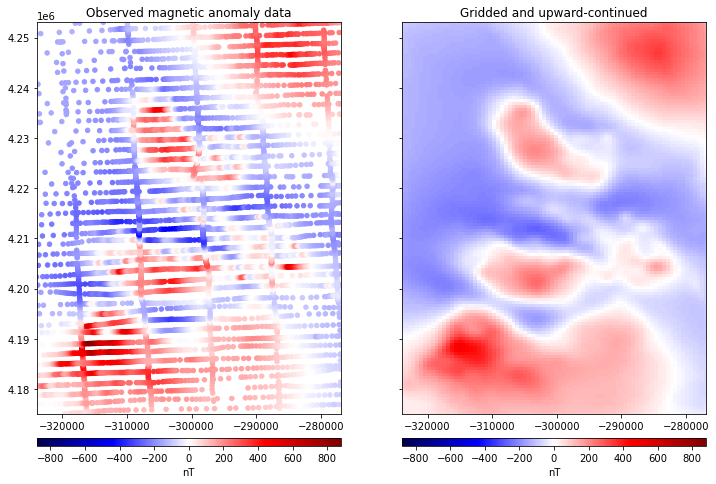

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pyproj
import verde as vd
import harmonica as hm


# Fetch the sample total-field magnetic anomaly data from Great Britain
data = hm.datasets.fetch_britain_magnetic()

# Slice a smaller portion of the survey data to speed-up calculations for this
# example
region = [-5.5, -4.7, 57.8, 58.5]
inside = vd.inside((data.longitude, data.latitude), region)
data = data[inside]
print("Number of data points:", data.shape[0])
print("Mean height of observations:", data.altitude_m.mean())

# Since this is a small area, we'll project our data and use Cartesian
# coordinates
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
easting, northing = projection(data.longitude.values, data.latitude.values)
coordinates = (easting, northing, data.altitude_m)

# Create the equivalent layer. We'll use the default point source configuration
# at a constant relative depth beneath each observation point. The damping
# parameter helps smooth the predicted data and ensure stability.
eql = hm.EQLHarmonic(relative_depth=1000, damping=1)

# Fit the layer coefficients to the observed magnetic anomaly.
eql.fit(coordinates, data.total_field_anomaly_nt)

# Evaluate the data fit by calculating an R² score against the observed data.
# This is a measure of how well layer the fits the data NOT how good the
# interpolation will be.
print("R² score:", eql.score(coordinates, data.total_field_anomaly_nt))

# Interpolate data on a regular grid with 500 m spacing. The interpolation
# requires the height of the grid points (upward coordinate). By passing in
# 1500 m, we're effectively upward-continuing the data (mean flight height is
# 500 m).
grid = eql.grid(upward=1500, spacing=600, data_names=["magnetic_anomaly"])

# The grid is a xarray.Dataset with values, coordinates, and metadata
print("\nGenerated grid:\n", grid)

# Plot original magnetic anomaly and the gridded and upward-continued version
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 9), sharey=True)

# Get the maximum absolute value between the original and gridded data so we
# can use the same color scale for both plots and have 0 centered at the white
# color.
maxabs = vd.maxabs(data.total_field_anomaly_nt, grid.magnetic_anomaly.values)

ax1.set_title("Observed magnetic anomaly data")
tmp = ax1.scatter(
    easting,
    northing,
    c=data.total_field_anomaly_nt,
    s=20,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="seismic",
)
plt.colorbar(tmp, ax=ax1, label="nT", pad=0.05, aspect=40, orientation="horizontal")
ax1.set_xlim(easting.min(), easting.max())
ax1.set_ylim(northing.min(), northing.max())

ax2.set_title("Gridded and upward-continued")
tmp = grid.magnetic_anomaly.plot.pcolormesh(
    ax=ax2,
    add_colorbar=False,
    add_labels=False,
    vmin=-maxabs,
    vmax=maxabs,
    cmap="seismic",
)
plt.colorbar(tmp, ax=ax2, label="nT", pad=0.05, aspect=40, orientation="horizontal")
ax2.set_xlim(easting.min(), easting.max())
ax2.set_ylim(northing.min(), northing.max())

plt.show()

In [4]:
# Upward continuation by EQL and FFT
grid_upward_eql = eql.grid(upward=11500, spacing=600, data_names=["magnetic_anomaly"])

grid_upward_fft=FFT_Filter(grid.magnetic_anomaly,[20,20]).upward_continuation(-10000)

C:\Users\22528618\Anaconda3\envs\fati\lib\site-packages\xrft\xrft.py:556: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


(4175067.7995107956, 4253040.094882049)

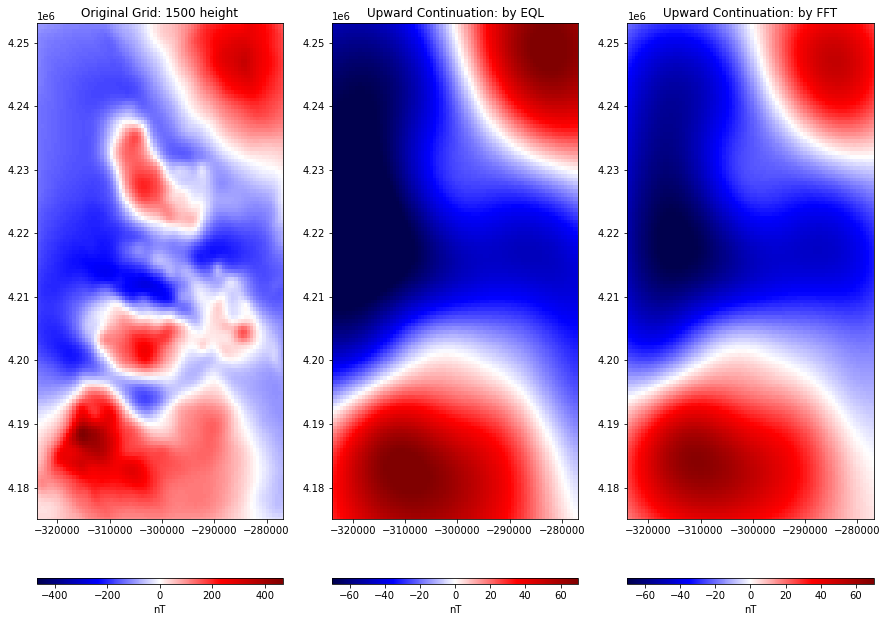

In [5]:
#Plot data

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 12))

# Get the maximum absolute value between the original and gridded data so we
# can use the same color scale for both plots and have 0 centered at the white
# color.
maxabs1 = vd.maxabs(grid.magnetic_anomaly.values)

ax1.set_title("Original Grid: 1500 height")
tmp1 = grid.magnetic_anomaly.plot.pcolormesh(
    ax=ax1,
    add_colorbar=False,
    add_labels=False,
    cmap="seismic",
)
plt.colorbar(tmp1, ax=ax1, label="nT", pad=0.09, aspect=40, orientation="horizontal")
ax1.set_xlim(grid.easting.min(), grid.easting.max())
ax1.set_ylim(grid.northing.min(), grid.northing.max())


ax2.set_title("Upward Continuation: by EQL")
tmp2 = grid_upward_eql.magnetic_anomaly.plot.pcolormesh(
    ax=ax2,
    add_colorbar=False,
    add_labels=False,
    vmin=-70,
    vmax=70,
    cmap="seismic",
)
plt.colorbar(tmp2, ax=ax2, label="nT", pad=0.09, aspect=40, orientation="horizontal")
ax2.set_xlim(grid.easting.min(), grid.easting.max())
ax2.set_ylim(grid.northing.min(), grid.northing.max())

ax3.set_title("Upward Continuation: by FFT")
tmp3 = grid_upward_fft.plot.pcolormesh(
    ax=ax3,
    add_colorbar=False,
    add_labels=False,
    vmin=-70,
    vmax=70,
    cmap="seismic",
)
plt.colorbar(tmp3, ax=ax3, label="nT", pad=0.09, aspect=40, orientation="horizontal")
ax3.set_xlim(grid.easting.min(), grid.easting.max())
ax3.set_ylim(grid.northing.min(), grid.northing.max())



## We can also combine filter or define filter by ourself

In [6]:
# Combine filters
Filter_1=FFT_Filter(grid.magnetic_anomaly).pseudo_gravity(I=60,D=90,savefilter=True)
Filter_2=FFT_Filter(grid.magnetic_anomaly).guassian_hp(20000,savefilter=True)

Filter_In=Filter_1*Filter_2

Test_1=FFT_Filter(grid.magnetic_anomaly).apply_filter(Filter_1)
Test_2=FFT_Filter(grid.magnetic_anomaly).apply_filter(Filter_In)

C:\Users\22528618\AppData\Local\Temp/ipykernel_58940/2184611736.py:418: RuntimeWarning: invalid value encountered in true_divide
  filter=(self.f_n**2+self.f_e**2)/((1j*(np.cos(I)*np.sin(D)*self.f_e+np.cos(I)*np.cos(D)*self.f_n)+
C:\Users\22528618\AppData\Local\Temp/ipykernel_58940/2184611736.py:355: RuntimeWarning: divide by zero encountered in power
  filter=np.power(np.sqrt(self.f_e**2+self.f_n**2),order)
C:\Users\22528618\Anaconda3\envs\fati\lib\site-packages\xrft\xrft.py:556: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
C:\Users\22528618\Anaconda3\envs\fati\lib\site-packages\xrft\xrft.py:556: FutureWarning: Default idft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureW

(4175067.7995107956, 4253040.094882049)

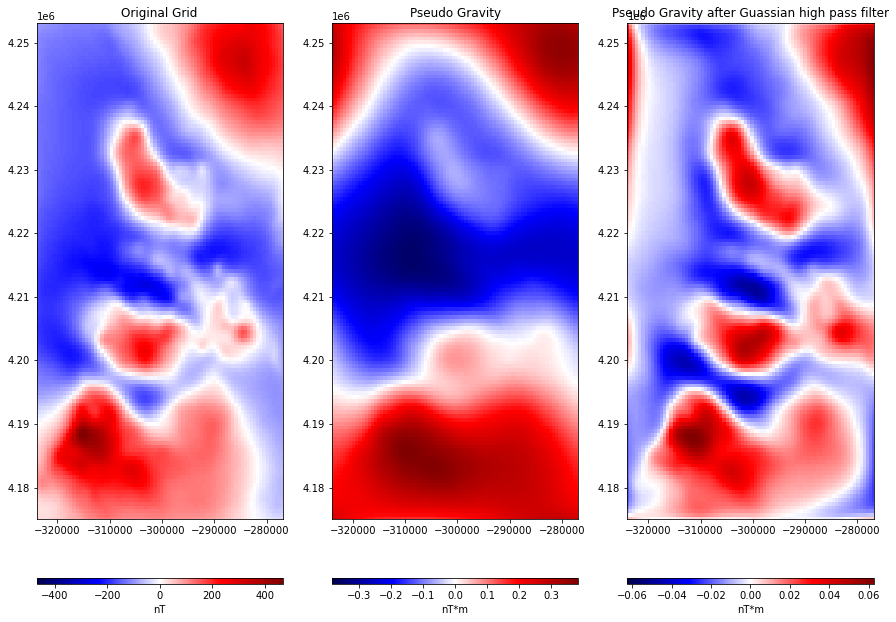

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 12))

# Get the maximum absolute value between the original and gridded data so we
# can use the same color scale for both plots and have 0 centered at the white
# color.
maxabs1 = vd.maxabs(grid.magnetic_anomaly.values)

ax1.set_title("Original Grid")
tmp1 = grid.magnetic_anomaly.plot.pcolormesh(
    ax=ax1,
    add_colorbar=False,
    add_labels=False,
    cmap="seismic",
)
plt.colorbar(tmp1, ax=ax1, label="nT", pad=0.09, aspect=40, orientation="horizontal")
ax1.set_xlim(grid.easting.min(), grid.easting.max())
ax1.set_ylim(grid.northing.min(), grid.northing.max())


ax2.set_title("Pseudo Gravity")
tmp2 = Test_1.plot.pcolormesh(
    ax=ax2,
    add_colorbar=False,
    add_labels=False,
    cmap="seismic",
)
plt.colorbar(tmp2, ax=ax2, label="nT*m", pad=0.09, aspect=40, orientation="horizontal")
ax2.set_xlim(grid.easting.min(), grid.easting.max())
ax2.set_ylim(grid.northing.min(), grid.northing.max())

ax3.set_title("Pseudo Gravity after Guassian high pass filter")
tmp3 = Test_2.plot.pcolormesh(
    ax=ax3,
    add_colorbar=False,
    add_labels=False,
    cmap="seismic",
)
plt.colorbar(tmp3, ax=ax3, label="nT*m", pad=0.09, aspect=40, orientation="horizontal")
ax3.set_xlim(grid.easting.min(), grid.easting.max())
ax3.set_ylim(grid.northing.min(), grid.northing.max())

